In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# # 归一化测试
# scaler = MinMaxScaler(feature_range=(-1, 1))
# data = np.arange(10).reshape(-1, 1)
# scaler.fit_transform(data).flatten()

In [3]:
def sliding_window(raw_data, window_size, stride=1):
    """
    """
    res = []
    left = right = 0
    while left + window_size <= len(raw_data):
        res.append(raw_data[left: left + window_size])
        left += stride
        right += stride
    return np.array(res, dtype=np.float32)

# def data_extend(voltage, current, temperature, window_size=225, stride=45):
#     """
#     """
#     assert len(voltage) == len(current) and len(current) == len(temperature), "Error!"
#     voltage_extend = sliding_window(voltage, window_size=window_size, stride=stride)
#     current_extend = sliding_window(current, window_size=window_size, stride=stride)
#     temperature_extend = sliding_window(temperature, window_size=window_size, stride=stride)

#     return np.array((voltage_extend, current_extend, temperature_extend))

def data_extend(x, y, z, window_size=225, stride=45):
    """
    """
    assert len(x) == len(y) and len(y) == len(z), "Error!"
    x_extend = sliding_window(x, window_size=window_size, stride=stride)
    y_extend = sliding_window(y, window_size=window_size, stride=stride)
    z_extend = sliding_window(z, window_size=window_size, stride=stride)

    return np.array((x_extend, y_extend, z_extend))

# def build_samples(voltage, current, temperature, target):
#     """
#     """
#     samples = []
#     data_extended = data_extend(voltage, current, temperature)
#     for j in range(data_extended.shape[1]):
#         seq = np.vstack((data_extended[0][j], data_extended[1][j], data_extended[2][j]))
#         samples.append((seq, target))
#     return np.array(samples, dtype=object)

def build_samples(x, y, z, target):
    """
    """
    samples = []
    data_extended = data_extend(x, y, z)
    for j in range(data_extended.shape[1]):
        seq = np.vstack((data_extended[0][j], data_extended[1][j], data_extended[2][j]))
        samples.append((seq, target))
    return np.array(samples, dtype=object)

# sliding_window 函数测试
raw_data = np.array(range(10))
data = sliding_window(raw_data=raw_data, window_size=3, stride=1)
# data_extend 函数测试
vol, cur, tem = raw_data, raw_data * 10, raw_data * 100
data_extended = data_extend(vol, cur, tem, window_size=2, stride=1)
print(data_extended.shape) # (num_features, num_windwos aka num_samples, window_size)
# build_samples 函数测试

(3, 9, 2)


In [4]:
dataset_path = "../../data/raw_data/tri/batch3.pkl"
with open(dataset_path, "rb") as f:
    dataset = pickle.load(f)

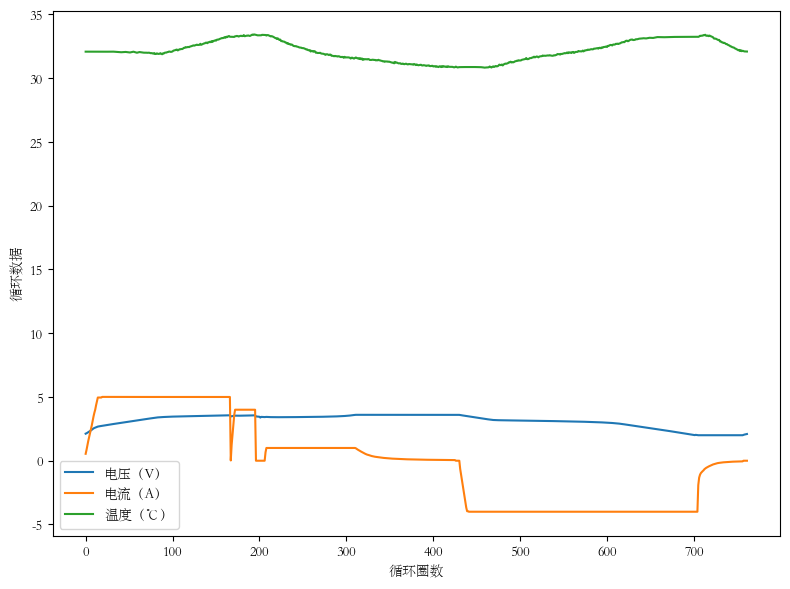

<Figure size 640x480 with 0 Axes>

In [5]:
idx = 0
key = list(dataset.keys())[idx]

dataset[key]["cycles"]["0"].keys()

plt.figure(figsize=(8, 6))
plt.plot(dataset[key]["cycles"]["0"]["V"])
plt.plot(dataset[key]["cycles"]["0"]["I"])
plt.plot(dataset[key]["cycles"]["0"]["T"])
plt.xlabel("循环圈数")
plt.ylabel("循环数据")
plt.legend(["电压（V）", "电流（A）", "温度（℃）"])
plt.tight_layout()
save_path = "../../assets/thesis_figures/chapter_4/tri_cycle_vit.jpg"
plt.savefig(save_path, dpi=1000, bbox_inches="tight")
plt.show()
plt.clf()

In [6]:
# 展示第一颗电芯第一个充放电循环电压电流和SOC曲线
idx = 0
key = list(dataset.keys())[idx]
rated_capacity = 1.1

print(dataset[key]["cycles"]["0"].keys())

def save_diagram(data, xlabel, ylabel, save_path):
    plt.figure(figsize=(8, 6))
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.clf()

save_diagram(dataset[key]["cycles"]["0"]["I"], "时间（s）", "电流（A）", "../../assets/thesis_figures/chapter_2/tri_b3c0_current.jpg")
save_diagram(dataset[key]["cycles"]["0"]["V"], "时间（s）", "电压（V）", "../../assets/thesis_figures/chapter_2/tri_b3c0_voltage.jpg")
save_diagram(dataset[key]["cycles"]["0"]["T"], "时间（s）", "温度（℃）", "../../assets/thesis_figures/chapter_2/tri_b3c0_temperature.jpg")
save_diagram((dataset[key]["cycles"]["0"]["Qc"] - dataset[key]["cycles"]["0"]["Qd"]) / rated_capacity, "时间（s）", "电池荷电状态", "../../assets/thesis_figures/chapter_2/tri_b3c0_soc.jpg")

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [7]:
batteries = dict()
keys = list(dataset.keys())[0:16] # 取前16块电芯数据
rated_capacity = 1.1

v_scaler = MinMaxScaler(feature_range=(0, 1))
i_scaler = MinMaxScaler(feature_range=(-1, 1))
t_scaler = MinMaxScaler(feature_range=(0, 1))
qc_scaler = MinMaxScaler(feature_range=(0, 1))
qd_scaler = MinMaxScaler(feature_range=(0, 1))

for idx, key in enumerate(keys):
    # 每次取一块电池的数据 dataset[key]
    
    # 构造循环数据
    # print(idx, dataset[key]["cycles"].keys())
    cycle_data = dict()
    for i in dataset[key]["cycles"].keys():
        cycle_data[int(i)] = {
            "V": v_scaler.fit_transform(dataset[key]["cycles"][i]["V"].astype(np.float32).reshape(-1, 1)).flatten(),
            "I": i_scaler.fit_transform(dataset[key]["cycles"][i]["I"].astype(np.float32).reshape(-1, 1)).flatten(),
            "T": t_scaler.fit_transform(dataset[key]["cycles"][i]["T"].astype(np.float32).reshape(-1, 1)).flatten(),
            "QC": qc_scaler.fit_transform(dataset[key]["cycles"][i]["Qc"].astype(np.float32).reshape(-1, 1)).flatten(),
            "QD": qd_scaler.fit_transform(dataset[key]["cycles"][i]["Qd"].astype(np.float32).reshape(-1, 1)).flatten(),
            "Q": qc_scaler.fit_transform(dataset[key]["cycles"][i]["Qc"].astype(np.float32).reshape(-1, 1)).flatten() - qd_scaler.fit_transform(dataset[key]["cycles"][i]["Qd"].astype(np.float32).reshape(-1, 1)).flatten(),
        }

    # 构造数据集
    batteries[idx] = {
        "cycle_len": int(dataset[key]["cycle_life"].item()) - 1,    # 循环圈数
        "charge_policy": dataset[key]["charge_policy"],             # 充放电配置
        "cycle_data": cycle_data,                                   # 循环数据
        "discharge_capacity": dataset[key]["summary"]["QD"]         # 放电容量
    }

# print("----- 电池数据 -----")
# for cnt in range(len(batteries)):
#     print(f"电池 {keys[cnt]} 的循环圈数： ", len(batteries[cnt]["cycle_data"].keys()))

# print("----- Battery 1 电池循环数据 -----")
# test_battery = batteries[0]
# print("循环圈数： ", test_battery["cycle_len"], "， 充电策略： ", test_battery["charge_policy"])
# print("放电容量： ", test_battery["discharge_capacity"])
# print("循环数据： ")
# # print(test_battery["cycle_data"])
# for key in test_battery["cycle_data"].keys():
#     print("  ", key, "：")
#     print("\t", test_battery["cycle_data"][key]) # 打印第一块电池每个循环的V、I、T、Q信息

In [8]:
# battery_names = list(batteries.keys())

# tri_capacity = []
# for key in batteries.keys():
#     tri_capacity.append(np.array(batteries[key]["discharge_capacity"]))
# tri_capacity = np.array(tri_capacity, dtype=object)

# # 创建大小为 (20, 10) 的大图，分成 4 行 4 列
# fig, axs = plt.subplots(4, 4, figsize=(25, 20))

# for i in range(16):
#     # 获取当前子图
#     ax = axs[i // 4, i % 4]
#     ax.plot(tri_capacity[i])
    
#     # 添加子图标题和x、y轴标签
#     ax.set_title(f'电池b3c{battery_names[i]}', fontsize=12)
#     ax.set_xlabel("循环圈数")
#     ax.set_ylabel("容量（Ah）")
#     ax.annotate(f'({chr(i+97)})\n', xy=(0.5, -0.2), fontsize=12, ha='center', va='center', xycoords='axes fraction')

# fig.suptitle("TRI数据集电池容量退化示意图\n\n\n")

# plt.tight_layout()
# plt.show()

In [9]:
# VIT
# 保存多元时间序列数据和标签到npy文件，格式为（sequence，target）
names = ["b3c" + str(num).rjust(2, "0") for num in range(16)]

save_path = "../../data/processed_data/tri/vit"
for idx, key in enumerate(keys):
    dataset = []
    cell = batteries[idx]
    cycle_len = cell["cycle_len"]
    # print(type(cycle_len), cycle_len)
    for i in range(cycle_len):
        # plt.plot(cell["cycle_data"][i]["V"]) # 绘制电压曲线
        # plt.plot(cell["cycle_data"][i]["I"]) # 绘制电流曲线
        # plt.plot(cell["cycle_data"][i]["T"]) # 绘制温度曲线
        # plt.plot((cell["cycle_data"][i]["QC"] - cell["cycle_data"][i]["QD"]) / rated_capacity) # 绘制SOC曲线（使用额定容量）
        # print(np.argmax((cell["cycle_data"][i]["QC"] - cell["cycle_data"][i]["QD"]) / rated_capacity)) # 返回SOC序列中的最大值索引，为充放电切换时刻
        samples = build_samples(cell["cycle_data"][i]["V"], cell["cycle_data"][i]["I"], cell["cycle_data"][i]["T"], cell["discharge_capacity"][i])
        dataset.append(samples)
    # 拉平数据集（消除充放电循环维度）
    dataset_to_save = []
    for cycle_data in dataset:
        for sample in cycle_data:
            dataset_to_save.append(np.array(sample))

    np.save(os.path.join(save_path, names[idx] + ".npy"), np.array(dataset_to_save))
    print(f"cell {key} data save to path: {os.path.join(save_path, names[idx] + '.npy')}")

cell b3c0 data save to path: ../../data/processed_data/tri/vit/b3c00.npy
cell b3c1 data save to path: ../../data/processed_data/tri/vit/b3c01.npy
cell b3c2 data save to path: ../../data/processed_data/tri/vit/b3c02.npy
cell b3c3 data save to path: ../../data/processed_data/tri/vit/b3c03.npy


In [ ]:
# VIq
# 保存多元时间序列数据和标签到npy文件，格式为（sequence，target）
names = ["b3c" + str(num).rjust(2, "0") for num in range(16)]

save_path = "../../data/processed_data/tri/viq"
for idx, key in enumerate(keys):
    dataset = []
    cell = batteries[idx]
    cycle_len = cell["cycle_len"]
    # print(type(cycle_len), cycle_len)
    for i in range(cycle_len):
        # plt.plot(cell["cycle_data"][i]["V"]) # 绘制电压曲线
        # plt.plot(cell["cycle_data"][i]["I"]) # 绘制电流曲线
        # plt.plot(cell["cycle_data"][i]["T"]) # 绘制温度曲线
        # plt.plot((cell["cycle_data"][i]["QC"] - cell["cycle_data"][i]["QD"]) / rated_capacity) # 绘制SOC曲线（使用额定容量）
        # print(np.argmax((cell["cycle_data"][i]["QC"] - cell["cycle_data"][i]["QD"]) / rated_capacity)) # 返回SOC序列中的最大值索引，为充放电切换时刻
        samples = build_samples(cell["cycle_data"][i]["V"], cell["cycle_data"][i]["I"], cell["cycle_data"][i]["Q"], cell["discharge_capacity"][i])
        dataset.append(samples)
    # 拉平数据集（消除充放电循环维度）
    dataset_to_save = []
    for cycle_data in dataset:
        for sample in cycle_data:
            dataset_to_save.append(np.array(sample))

    np.save(os.path.join(save_path, names[idx] + ".npy"), np.array(dataset_to_save))
    print(f"cell {key} data save to path: {os.path.join(save_path, names[idx] + '.npy')}")

In [ ]:
# import random
# random.seed(0)
# num = random.randint(0, 15)
# print(num) # 12

# 读取数据测试
path = "../../data/processed_data/tri/viq/b3c12.npy"
load_data = np.load(path, allow_pickle=True) # 11761
print(load_data.shape) # (11761, 2)

# 训练/验证过程中如何读取数据集？
# print(load_data[0])
cap = []
for sample in load_data:
    target = sample[1]
    cap.append(target)

# for X, y in load_data:
#     print(X)
#     print(y)
#     break

plt.plot(cap)